In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import parallel_backend
from sklearn.pipeline import Pipeline


In [3]:
# Define the file path and name
file_path = '/Users/shchan/Documents/Programming/Postgrad_Computer_science/Modules/CSCK503 Machine Learning in Practice June 2024/Week 8/Assignment/end of module assignment/data/'
# merge_file_name = 'MajorRoadTrafficData.csv'
file_name = 'PivotedMajorRoadTrafficData.csv'

# file_path = '../data/MajorRoadTrafficData.csv'
df = pd.read_csv(file_path+file_name)

In [4]:
#
# Step 1: Handling Missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Step 2: Removing Duplicates
df = df.drop_duplicates()

# Drop rows with NaN in 'CO2 emission'
df = df.dropna(subset=['CO2 emission'])
# Print the number of rows after dropping
print(f"Number of rows after dropping NaN in 'CO2 emission': {df.shape[0]}")



# Step 3: Outlier Detection and Treatment using IQR method
numeric_df = df.select_dtypes(include=[np.number])


Q1 = numeric_df.quantile(0.25, numeric_only=True)
Q3 = numeric_df.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Aligning DataFrame and IQR series for proper comparison
df_aligned, IQR_aligned = df.align(IQR, axis=1, copy=False)
Q1_aligned, _ = df.align(Q1, axis=1, copy=False)
Q3_aligned, _ = df.align(Q3, axis=1, copy=False)

df = df[~((df_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (df_aligned > (Q3_aligned + 1.5 * IQR_aligned))).any(axis=1)]

# 

# 
# 
# # Step 1: Handling Missing values
# missing_values = df.isnull().sum()
# print("Missing values in each column:\n", missing_values)

# # Step 2: Removing Duplicates
# df = df.drop_duplicates()

# # Step 3: Outlier Detection and Treatment using IQR method
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1

# # Aligning DataFrame and IQR series for proper comparison
# df_aligned, IQR_aligned = df.align(IQR, axis=1, copy=False)
# Q1_aligned, _ = df.align(Q1, axis=1, copy=False)
# Q3_aligned, _ = df.align(Q3, axis=1, copy=False)

# df = df[~((df_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (df_aligned > (Q3_aligned + 1.5 * IQR_aligned))).any(axis=1)]

Missing values in each column:
 GridId                        0
Toid                          0
GRID_ExactCut_ID              0
Location_ExactCut             0
BoroughName_ExactCut          0
Lts                           0
Length (m)                    0
Emissions                     0
Year                          0
Emissions Unit                0
VehicleType                   0
RowID                         0
TLRN                          0
MotorwayNumber                0
Speed (kph)                   0
AADT                          0
VKM                           0
CO2 emission             336912
NOx emission             336912
PM10_Brake emission      336912
PM10_Exhaust emission    336912
PM10_Resusp emission     336912
PM10_Tyre emission       336912
PM25_Brake emission      336912
PM25_Exhaust emission    336912
PM25_Resusp emission     336912
PM25_Tyre emission       336912
dtype: int64
Number of rows after dropping NaN in 'CO2 emission': 336912


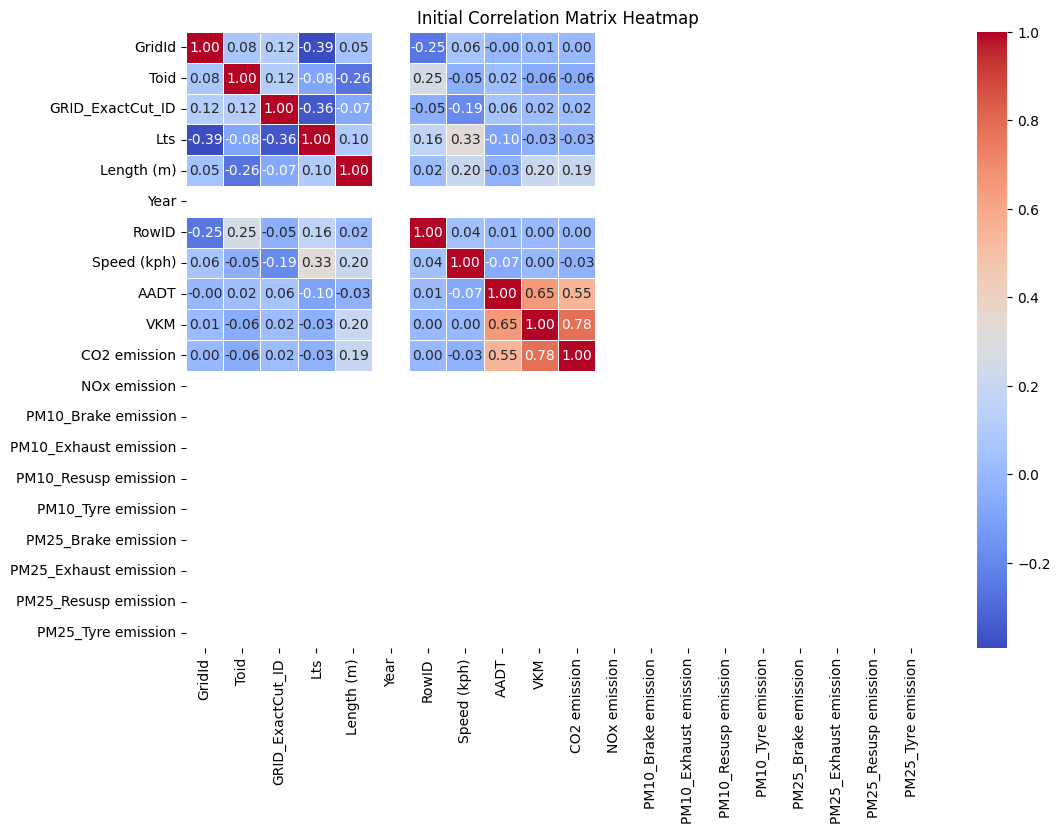

In [4]:
# Filter numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Initial heatmap of the correlation matrix
initial_correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(initial_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Initial Correlation Matrix Heatmap')
plt.show()

# # Initial heatmap of the correlation matrix
# initial_correlation_matrix = df.corr()

# plt.figure(figsize=(12, 8))
# sns.heatmap(initial_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Initial Correlation Matrix Heatmap')
# plt.show()

In [5]:
# Encode categorical variables
categorical_columns = ['Location_ExactCut', 'BoroughName_ExactCut', 'Emissions', 'Emissions Unit', 'VehicleType', 'TLRN','MotorwayNumber']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    df[col] = label_encoders[col].fit_transform(df[col])

# Calculate correlation matrix after encoding
encoded_correlation_matrix = df.corr()

# Correlation with the target variable
target_corr = encoded_correlation_matrix['CO2 emission'].abs().sort_values(ascending=False)
print(target_corr)

CO2 emission             1.000000
VKM                      0.778763
AADT                     0.546873
Length (m)               0.193900
VehicleType              0.075468
Toid                     0.055850
Speed (kph)              0.032406
Lts                      0.031983
GRID_ExactCut_ID         0.018073
BoroughName_ExactCut     0.017632
Location_ExactCut        0.004152
TLRN                     0.003344
RowID                    0.002650
GridId                   0.002186
Emissions                     NaN
Year                          NaN
Emissions Unit                NaN
MotorwayNumber                NaN
NOx emission                  NaN
PM10_Brake emission           NaN
PM10_Exhaust emission         NaN
PM10_Resusp emission          NaN
PM10_Tyre emission            NaN
PM25_Brake emission           NaN
PM25_Exhaust emission         NaN
PM25_Resusp emission          NaN
PM25_Tyre emission            NaN
Name: CO2 emission, dtype: float64


In [1]:
# Select features with correlation greater than 0.05
selected_features = target_corr[target_corr > 0.05].index.tolist()
print(selected_features)
# # Add the target variable back to the selected features
selected_features.append('CO2 emission')

df['Interaction_Length_Speed'] = df['Length (m)'] * df['Speed (kph)']
df['Interaction_AADT_VKM'] = df['AADT'] * df['VKM']

# # Redefine features and preprocess again
# selected_features = selected_features + ['Interaction_Length_Speed', 'Interaction_AADT_VKM']

# Plot final heatmap with Emission Value
final_correlation_matrix_with_target = df[selected_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap with Target')
plt.show()

NameError: name 'target_corr' is not defined

In [33]:
# Final dataset with selected features, drop 'Emission Value' for training features
X = df[selected_features].drop(columns=['CO2 emission'])
y = df['CO2 emission']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Print the final selected features
print(X_scaled_df.head())

        VKM      AADT  Length (m)  VehicleType      Toid
0  0.073929 -0.085386    0.484292    -1.593255 -6.324617
1  0.203090  0.022644    0.484292    -1.303572 -6.324617
2 -0.004691 -0.151143    0.484292    -1.013890 -6.324617
3 -0.246166 -0.353113    0.484292    -0.724207 -6.324617
4 -0.234303 -0.343190    0.484292    -0.434524 -6.324617


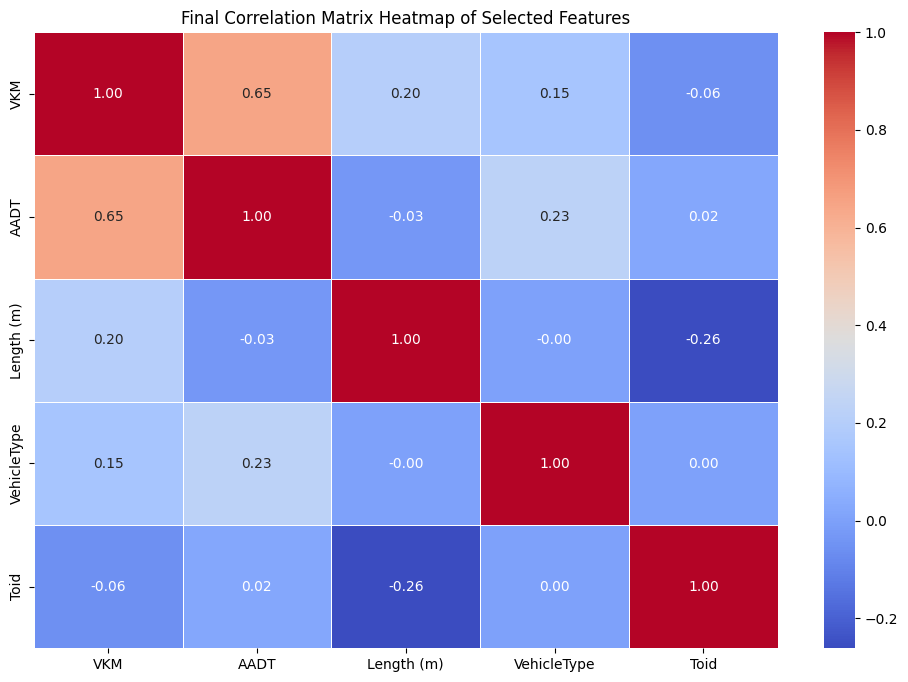

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Final heatmap of the correlation matrix without the target
final_correlation_matrix = X_scaled_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap of Selected Features')
plt.show()

In [35]:
# The dataset is now ready for ML training
dataset_info = {
    "X_train_shape": X_train.shape,
    "X_test_shape": X_test.shape,
    "y_train_shape": y_train.shape,
    "y_test_shape": y_test.shape,
    "features": selected_features[:-1],  # exclude the target from features
    "target": 'Emission Value'
}

print(dataset_info)

{'X_train_shape': (269529, 5), 'X_test_shape': (67383, 5), 'y_train_shape': (269529,), 'y_test_shape': (67383,), 'features': ['CO2 emission', 'VKM', 'AADT', 'Length (m)', 'VehicleType'], 'target': 'Emission Value'}


In [36]:
# Train and evaluate Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)

In [37]:
# Define and test a few hyperparameter combinations
rf1 = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf1.fit(X_train, y_train)
y_pred_rf1 = rf1.predict(X_test)

rf2 = RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf2.fit(X_train, y_train)
y_pred_rf2 = rf2.predict(X_test)

In [38]:
# Define the neural network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred_nn = nn_model.predict(X_test).flatten()

Epoch 1/50


/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step - loss: 8.8243 - val_loss: 5.3745
Epoch 2/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step - loss: 4.1448 - val_loss: 3.2478
Epoch 3/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step - loss: 3.8316 - val_loss: 2.5519
Epoch 4/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step - loss: 2.6000 - val_loss: 2.2606
Epoch 5/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step - loss: 3.4581 - val_loss: 2.0273
Epoch 6/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step - loss: 2.0321 - val_loss: 5.2278
Epoch 7/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step - loss: 1.9068 - val_loss: 1.8698
Epoch 8/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step - loss: 2.1370 - val_loss: 1.9788
Epoch 9/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step - loss: 1.7350 - val_loss: 2.2674
Epoch 10/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step - loss: 1.9882 - val_loss: 1.9643
Epoch 11/50
6739/6739 ━━━━━━━━━━━━━━━━━━━━ 3s 379us/step - loss: 2.7720 - val_loss: 2.0699
Epoch 12/50
6739/67

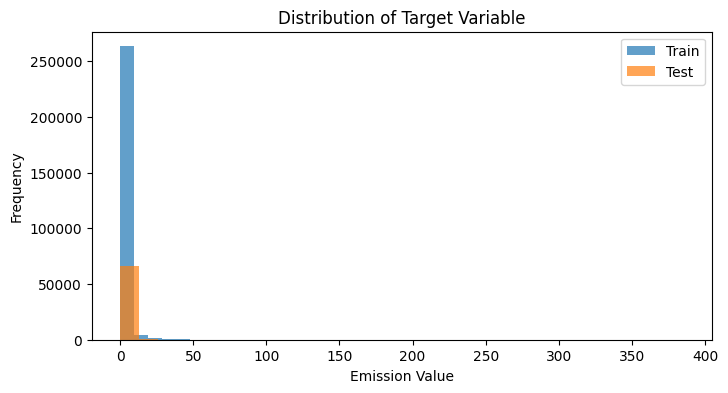

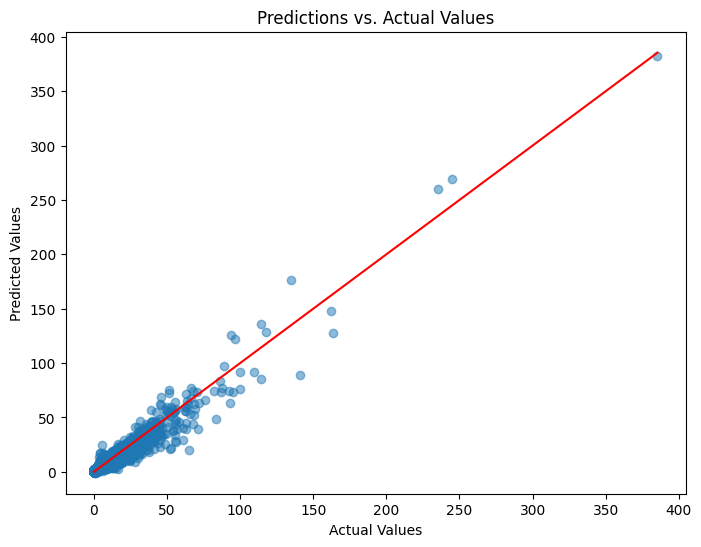

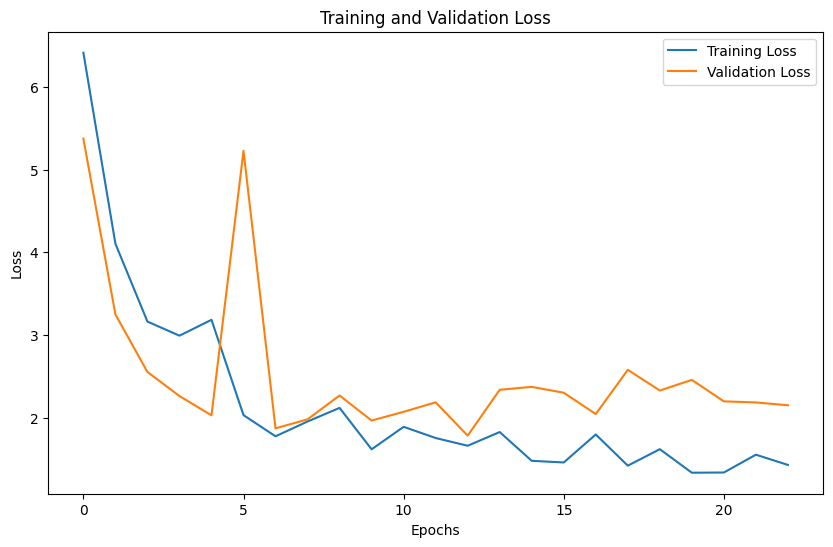

In [39]:
# Plot the distribution of target values
plt.figure(figsize=(8, 4))
plt.hist(y_train, bins=30, alpha=0.7, label='Train')
plt.hist(y_test, bins=30, alpha=0.7, label='Test')
plt.title('Distribution of Target Variable')
plt.xlabel('Emission Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title('Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Evaluate Models
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

linear_metrics = evaluate_model(y_test, y_pred_lr)
rf1_metrics = evaluate_model(y_test, y_pred_rf1)
rf2_metrics = evaluate_model(y_test, y_pred_rf2)

nn_metrics = evaluate_model(y_test, y_pred_nn)

print("Linear Regression Metrics (MAE, MSE, R^2):", linear_metrics)
print("Random Forest Metrics (MAE, MSE, R^2):", rf1_metrics)
print("Random Forest Metrics (MAE, MSE, R^2):", rf2_metrics)
print("Neural Network Metrics (MAE, MSE, R^2):", nn_metrics)

Linear Regression Metrics (MAE, MSE, R^2): (0.7872669476628872, 6.171706235283784, 0.685513435083883)
Random Forest Metrics (MAE, MSE, R^2): (0.3292204752712701, 1.4905863484937432, 0.9240454158740268)
Random Forest Metrics (MAE, MSE, R^2): (0.15997028572519156, 0.8937579304278687, 0.9544575113118821)
Neural Network Metrics (MAE, MSE, R^2): (0.6775061022345559, 1.2966224459246811, 0.933929075126623)
